# Compare seismic features with geodetic data

These features were calculated on the `kebo` machine with  approximately ten years of continuous data (broadband and three-components). They used long-duration windows (typically half hour long) and twenty-ish components and clusters. The goal is to investigate the relationship with the geodetic data.

In [1]:
import os
import pickle

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import explained_variance_score
import figures

## Global parameters

In [2]:
NETWORK = "network_1"
POOLING = "max"
REDUCTION = "fastica_20"
SUFFIX = f"{REDUCTION}"
DIRPATH_FIGURES = f"./paper/{POOLING}"
FILEPATH_FEATURES = f"./out/{NETWORK}_{POOLING}_{SUFFIX}.pkl"
FILEPATH_DATABASE = "./data/mseed_database/IG.ARIG.BH.sqlite-index.pkl"
FILEPATH_NETWORK = f"./model/{NETWORK}.pkl"
FILEPATH_SCATTERINGS = f"./out/{NETWORK}_{POOLING}.pkl"
FILEPATH_CATALOG = "./data/catalogs/tremors_S1_husker.csv"
FILEPATH_GPS = "data/gps/gps_detrended_smooth_2.pkl"

# Create the directory for the figures if it does not exist.
os.makedirs(DIRPATH_FIGURES, exist_ok=True)

# Print out file
print(f"Figures will be saved in {DIRPATH_FIGURES}")

Figures will be saved in ./paper/max


## Read results

Some outputs were downloaded locally.

In [6]:
# Load the features
features = pickle.load(open(FILEPATH_FEATURES, "rb"))

# Load the gps data
gps = pickle.load(open(FILEPATH_GPS, "rb"))

# Get if x is features or clusters
x_feature_name = "feature"
n_features = len(features.feature)

## Everybody on the same page (interpolate on same dates)

We also observe the smoothed features in order to better investigate long-duration trends in the features. We do this with a rolling windows associated with a mean. The result is non-causal (centered) with a minimum sample of 1.

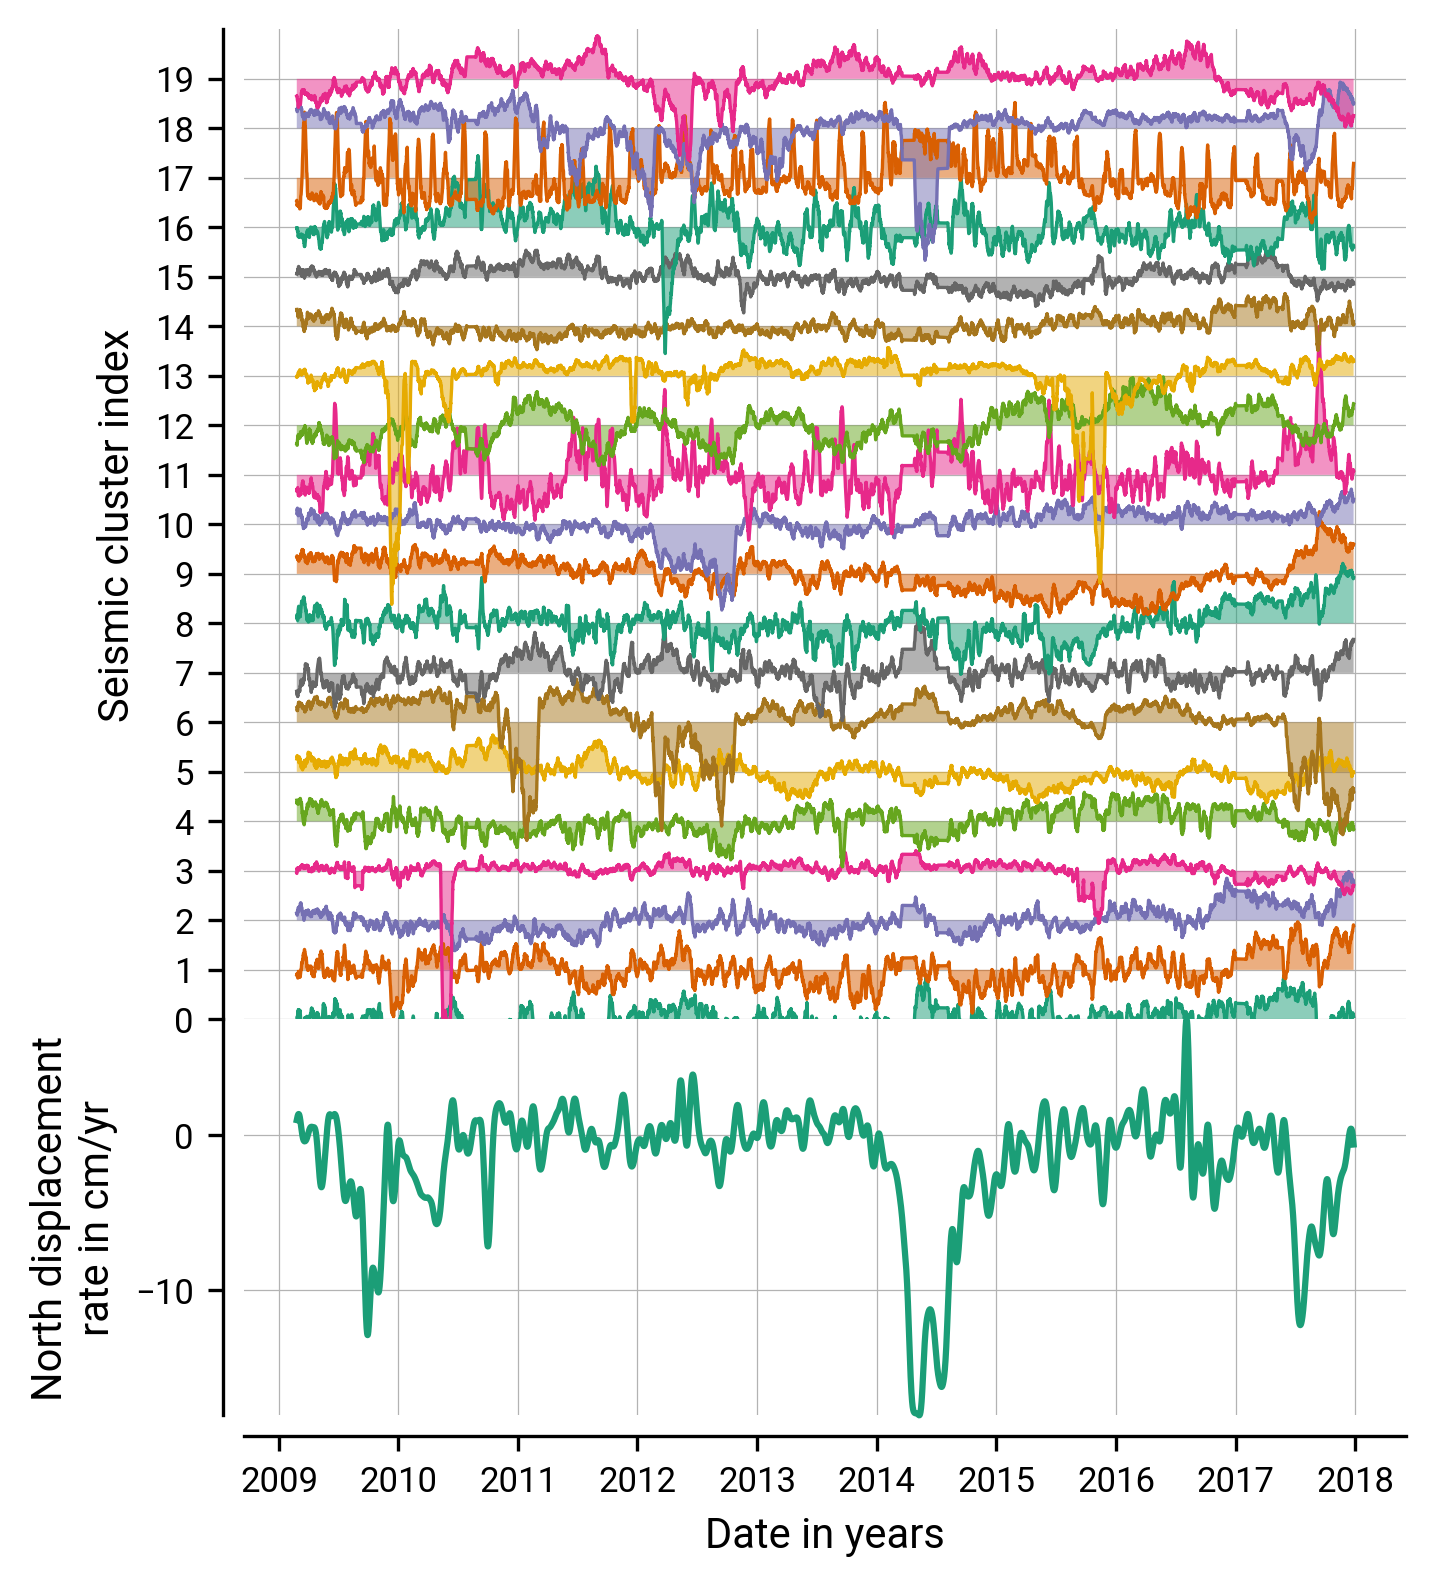

In [7]:
# Define a common time axis
start = max(gps.time.min(), features.time.min())
end = min(gps.time.max(), features.time.max())
step = np.timedelta64(6, "h")
times = np.arange(start.data, end.data, step)

# Interpolate
x_interp = features["features"].copy().rolling(time=10 * 2 * 24, center=True).mean()
x_slow = x_interp.interp(time=times)
x_slow = x_slow.dropna("time")

# Normalize
x_norm = x_slow.copy()
# x_norm = (x_norm - x_norm.min(dim="time")) / (x_norm.max(dim="time") -
# x_norm.min(dim="time"))
# x_norm = x_norm / x_norm.sum(dim="time")
x_norm /= x_norm.max() / 3

# Limit y to the same time period as x
gps = gps.sel(time=slice(features.time.min(), features.time.max()))

# Resample and interpolate
y_interp = gps.resample(time="6h").interpolate().interp(time=x_slow.time)

# Plot
sns.set_palette("Dark2")
ax = figures.compare(x_norm.T, y_interp, components=("north",), dim="feature")
plt.show()

## Regression with scikit-learn

In [8]:
# from sklearn import svm
from sklearn.linear_model import LinearRegression

EXPO = 1

# Define design matrix
x_norm = x_slow.copy()  #- x_slow.min(dim="time")
design = x_norm.T.copy() ** EXPO

# Filter out unwanted components
target = y_interp.sel(component="north", drop=True).copy()
print(design.shape)
print(target.shape)

# Solve linear system
model = LinearRegression(fit_intercept=False)
# model = svm.SVR()
model.fit(design.to_numpy(), target.to_numpy())

# Reconstruct
prediction = target.copy()
prediction.values = model.predict(design.to_numpy())

# # Get feature-wise contribution
# contribution = np.zeros_like(model.coef_)
# for index in range(len(model.coef_)):
#     pred = model.coef_[index] * design[index].to_numpy()
#     contribution[index] = np.std(pred)

# # Sort with respect to contribution
# indices = np.argsort(contribution)[::-1]
# coefficients = model.coef_[indices]
# design = design[indices]

# Overall score
score = np.corrcoef(target.values, prediction.values)[0, 1]
# print(model.intercept_)

(12910, 20)
(12910,)


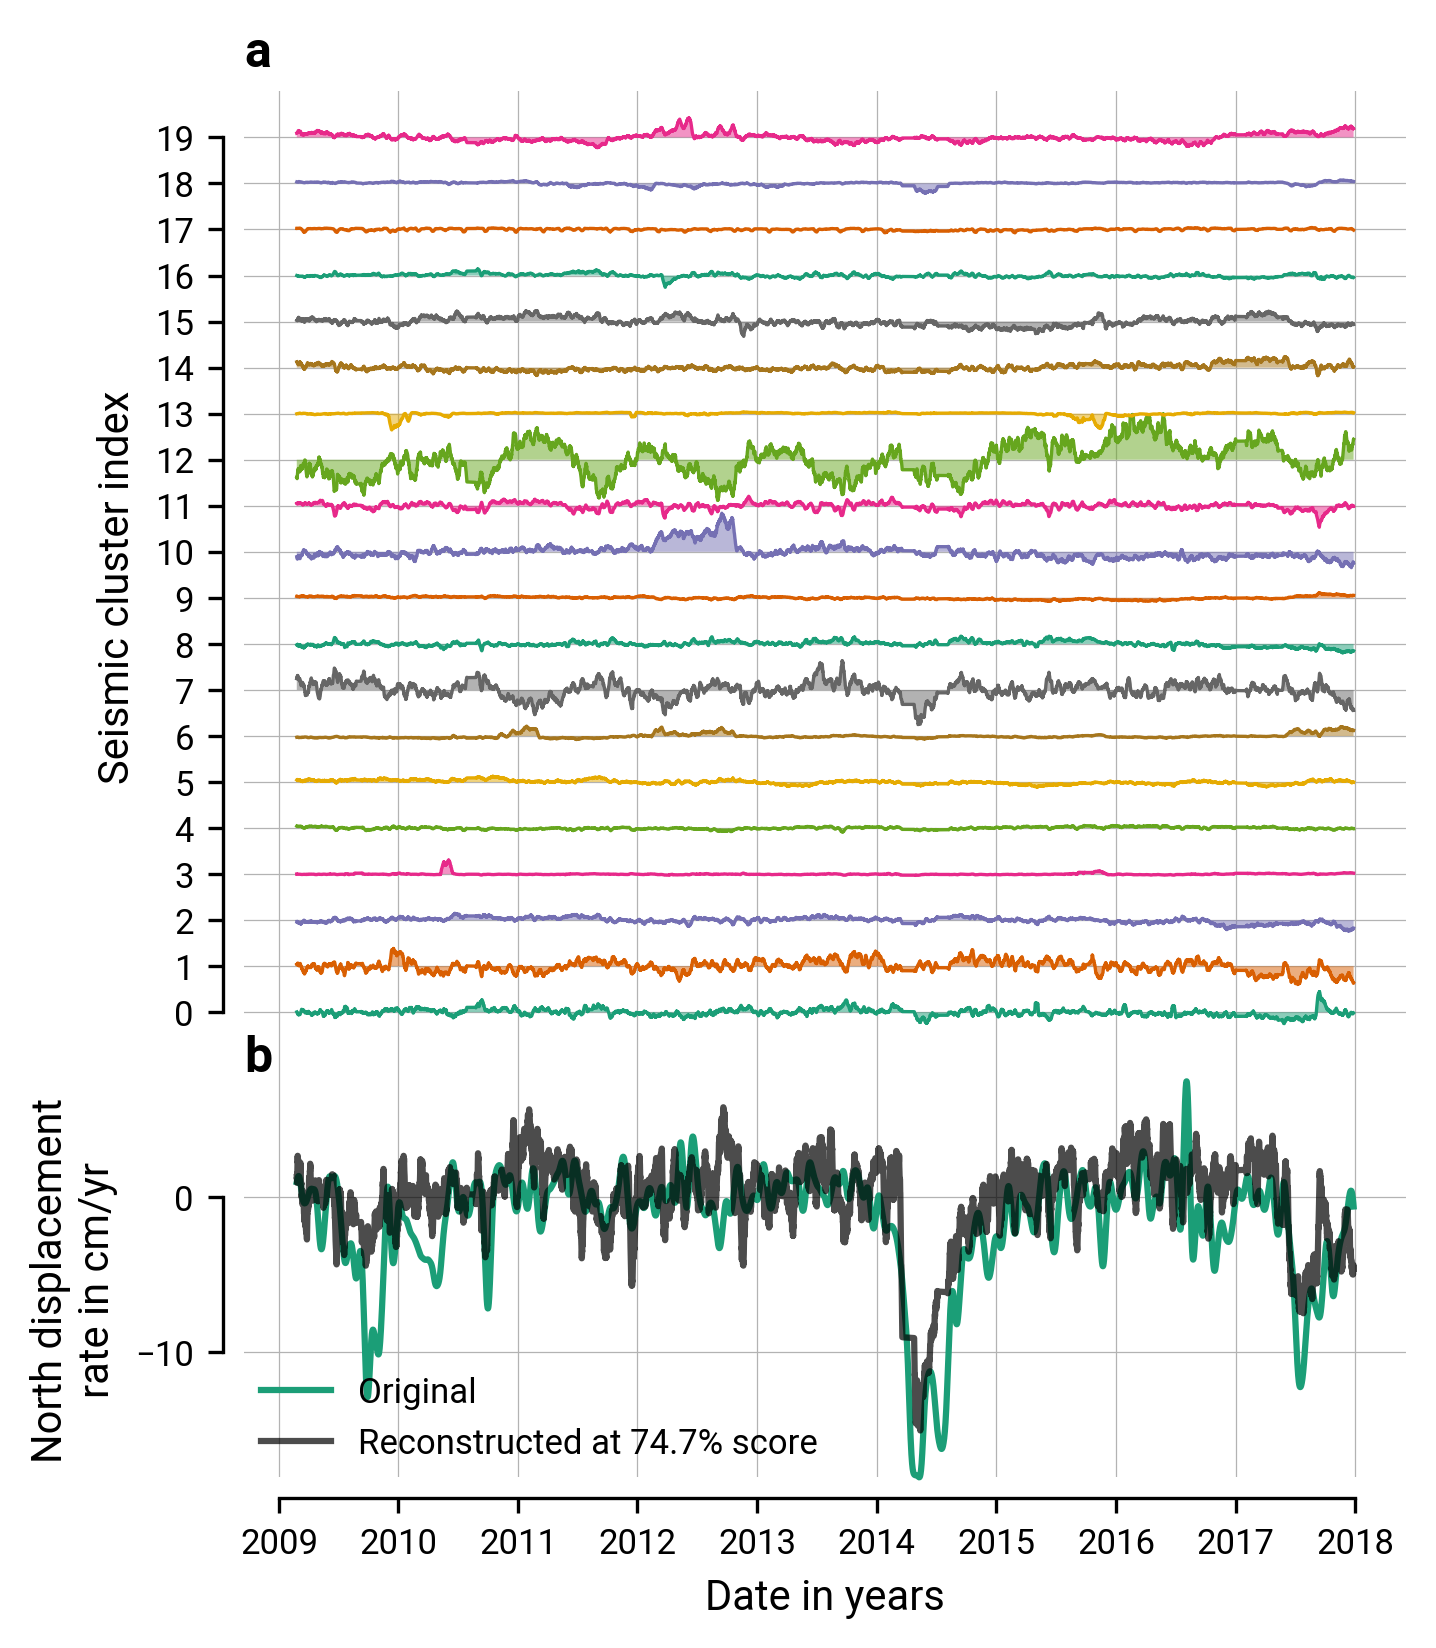

In [9]:

# Weighted inputs
# x_weighted = coefficients[:, None] * design 
# x_weighted /= x_weighted.max()
x_weighted = design.copy().T
for index in range(len(x_weighted.feature)):
    selected = design.where(design.feature == index, 0)
    x_weighted[index] = model.predict(selected.to_numpy())
x_weighted /= x_weighted.max() 

# Subplots
sns.set_palette("Dark2")
ax = figures.compare(x_weighted.T, y_interp.T, components=("north",), dim="feature")
ax[-1].set_ylim(target.values.min(), target.values.max())
ax[-1].plot(prediction.time, prediction, alpha=0.7, c="k")
ax[0].set_ylim(-1.5, len(x_weighted.feature))
ax[0].set_yticks(np.arange(len(x_weighted.feature)))
# ax[0].set_yticklabels(np.arange(len(model.coef_)[indices])
ax[0].set_title("a", loc="left")
ax[1].set_title("b", loc="left", pad=-20, va="top")
sns.despine(ax=ax[0], trim=True, offset=5, bottom=True)
sns.despine(ax=ax[1], trim=True, offset=5)
ax[1].legend(["Original", f"Reconstructed at {score:0.1%} score"], loc="lower left")

# Show 
# plt.savefig(f"{DIRPATH_FIGURES}/e2_compare_{EXPO}_{SUFFIX}.pdf", bbox_inches="tight")

## Regression

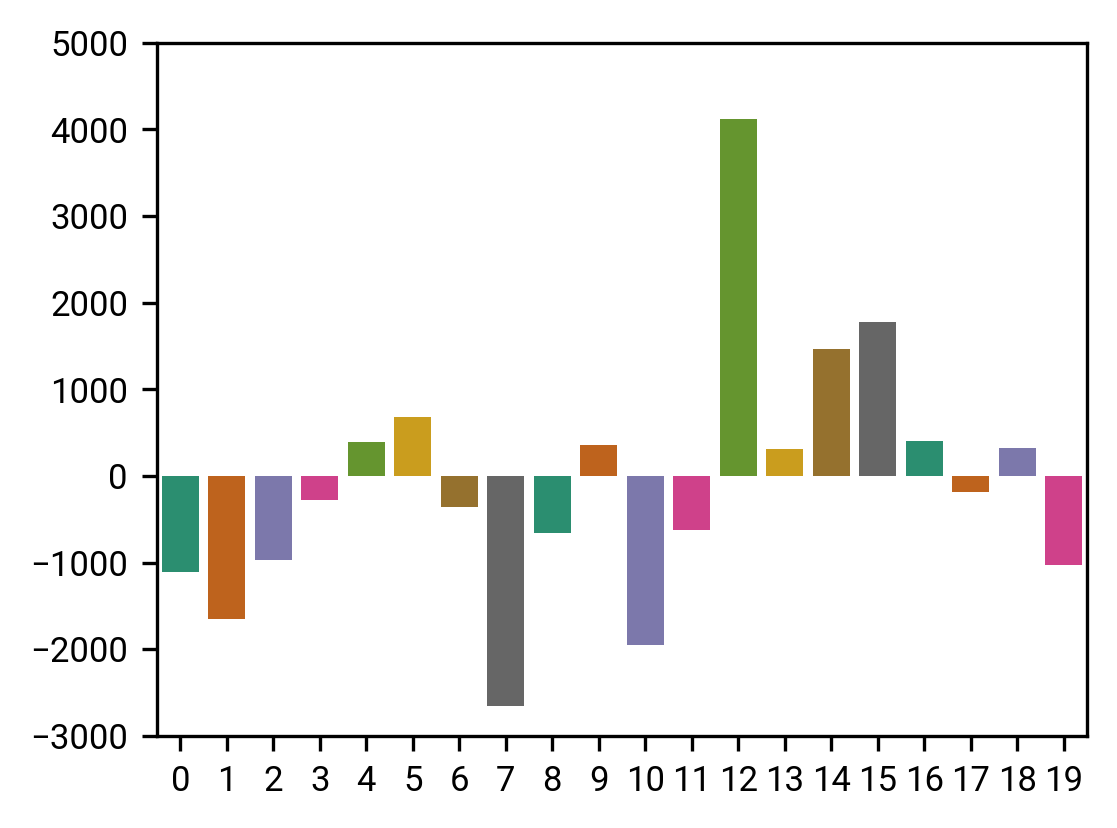

[-1108.79149036 -1648.2319093   -971.86982998  -271.95618225
   393.31748351   677.91397314  -356.7393952  -2653.27026298
  -652.73475938   362.28650575 -1952.18675339  -627.82825703
  4120.49973504   308.88428246  1465.99005105  1782.12861006
   404.86498451  -190.4386935    326.65969243 -1031.65024406]


In [10]:
plt.figure()
# sns.barplot(y=contribution[indices], x=np.arange(len(contribution)), palette="Dark2")
# sns.barplot(y=model.coef_[indices], x=np.arange(len(contribution)),
# palette="Dark2")
sns.barplot(x=np.arange(len(model.coef_)), y=model.coef_, palette="Dark2")
# plt.gca().set_xticklabels(indices)
plt.show()
print(model.coef_)

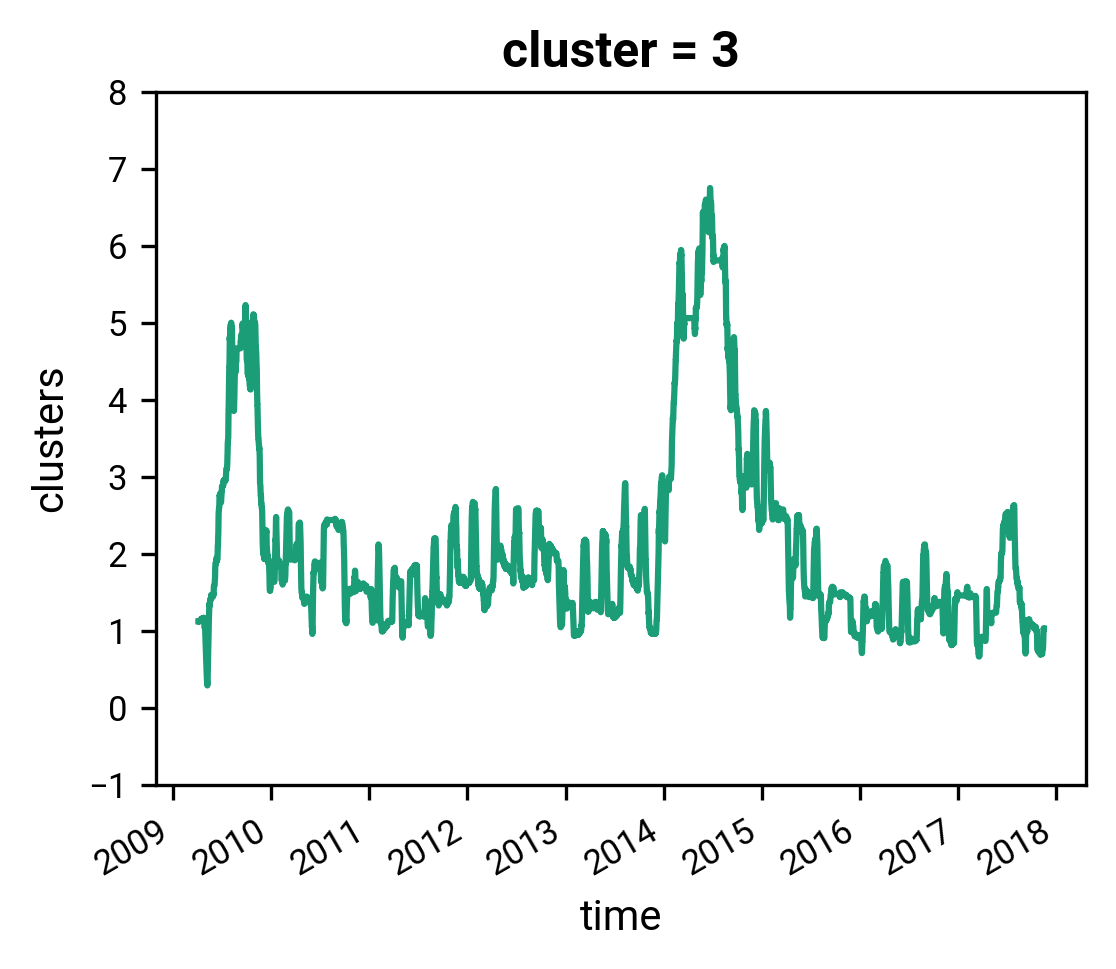

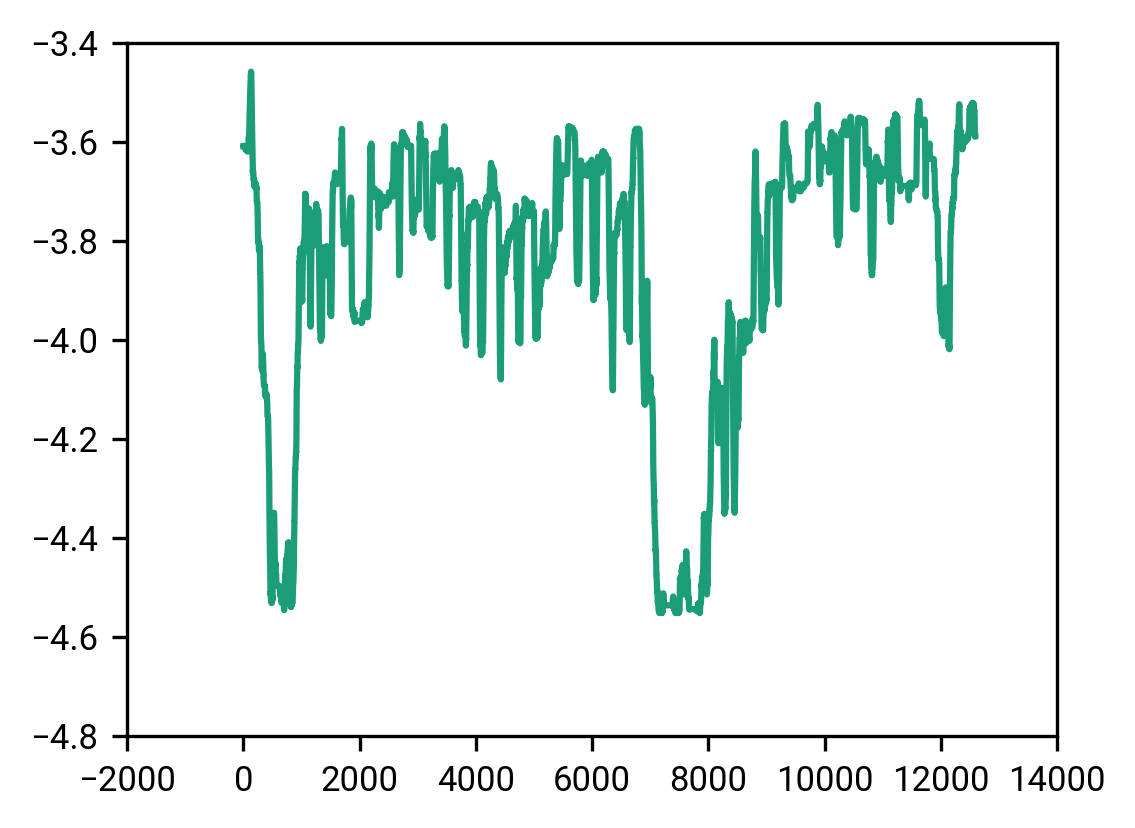

In [105]:
selected = design.where(design.cluster == 3, 0)
selected.sel(cluster=3).plot()
plt.figure()
plt.plot(model.predict(selected.to_numpy().T))
# print(selected.sel(cluster=8).min())

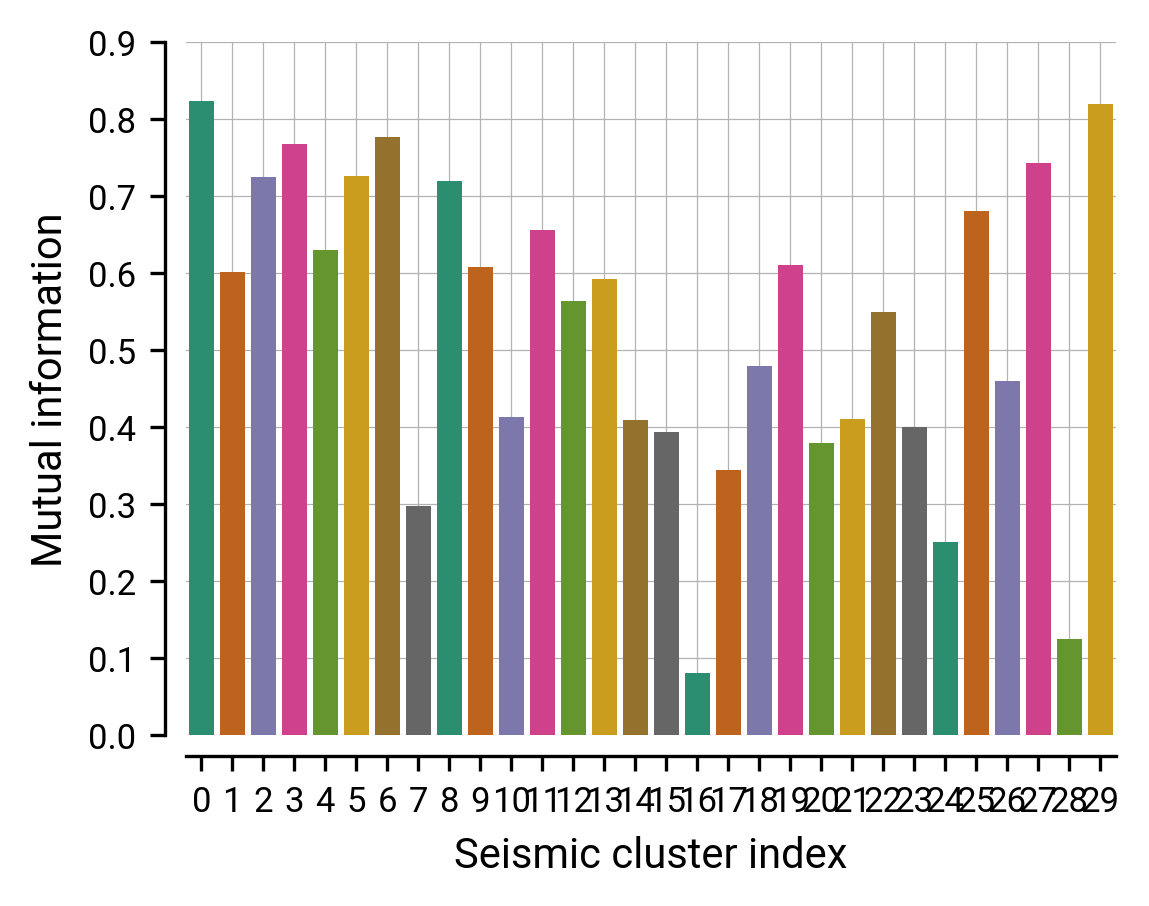

In [43]:
from sklearn.feature_selection import mutual_info_regression

# Compute mutual information
mi = mutual_info_regression(design.to_numpy().T, target.to_numpy())

fig, ax = plt.subplots()
sns.barplot(y=mi, x=np.arange(len(features.cluster)), palette="Dark2")
ax.grid(True)
ax.set_ylabel("Mutual information")
ax.set_xlabel("Seismic cluster index")
sns.despine(offset=5, ax=ax)

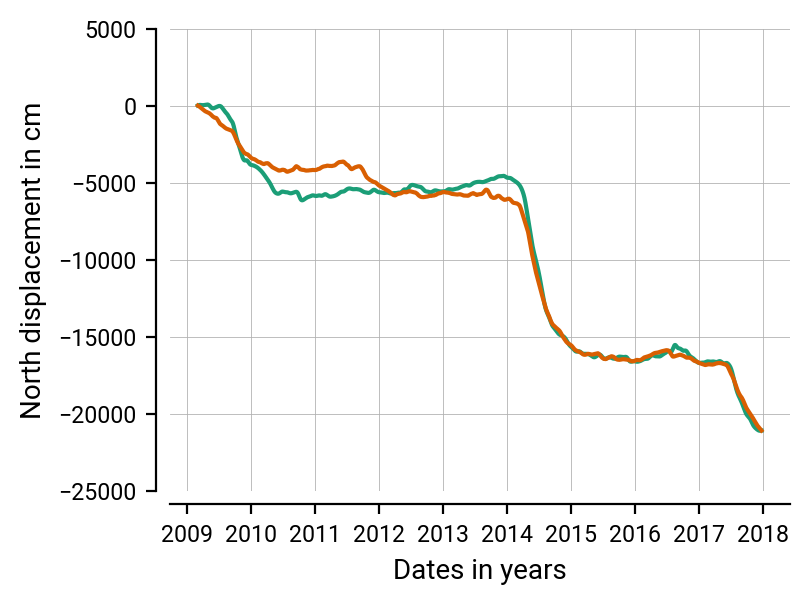

In [45]:
# Subplots
fig = plt.figure(dpi=200)
ax = plt.axes()

# Integrate
ax.plot(target.time, target.cumsum(), label="Target")
ax.plot(target.time, prediction.cumsum(), label="Target")
ax.set_xlabel("Dates in years")
ax.set_ylabel("North displacement in cm")
ax.grid()

# Seaborn
sns.despine(offset=5, ax=ax)

(12591, 4)


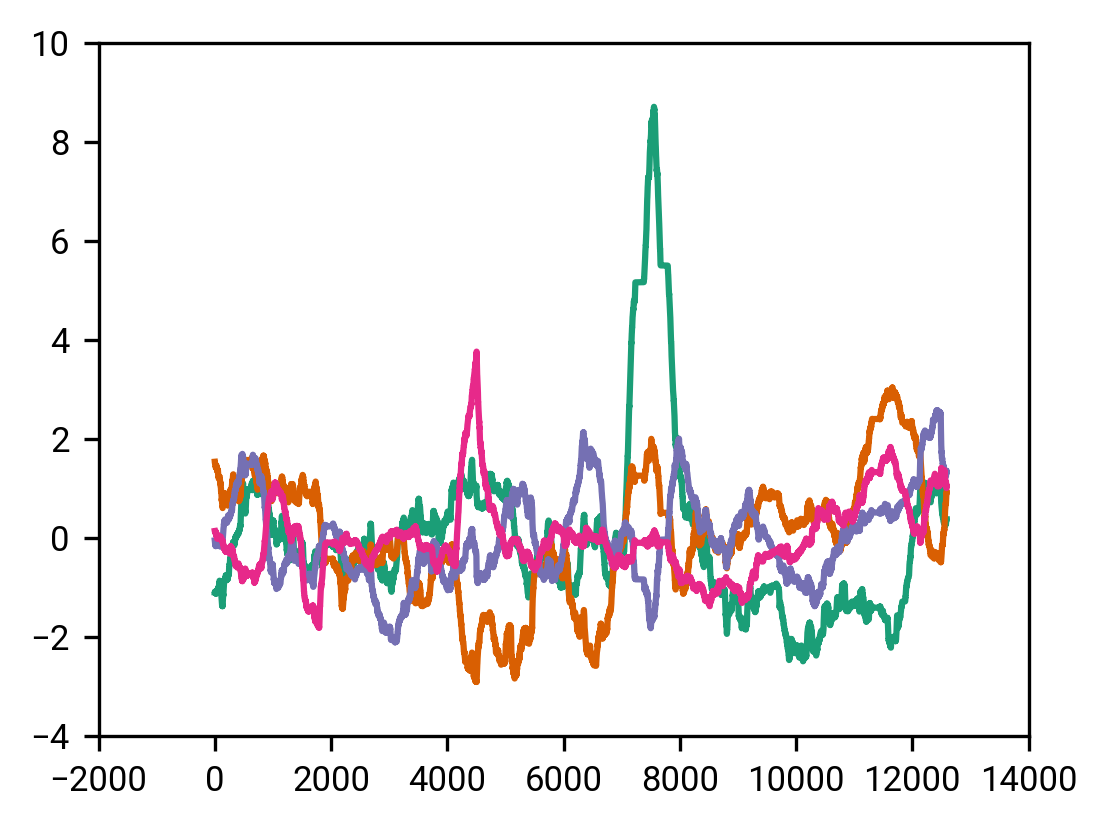